<a href="https://colab.research.google.com/github/mounishsjsu/266_Project/blob/master/266_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install pyspark

In [41]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,SQLContext
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pyspark.sql.types import IntegerType
import seaborn as sns
import re
from textblob import TextBlob

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Check if a SparkContext already exists
if 'sc' not in globals():
    conf = SparkConf().setMaster("local").setAppName("Weather analysis")
    sc = SparkContext(conf=conf)
    spark = SparkSession(sc)
    sqlContext = SQLContext(sc)
else:
    # Use the existing SparkContext
    sc = SparkContext.getOrCreate()
    spark = SparkSession(sc)
    sqlContext = SQLContext(sc)


In [44]:
df = spark.read.option("header",'true').csv("/content/city_temperature.csv",inferSchema=True)

In [45]:
print(df.head(3))

[Row(Region='Africa', Country='Algeria', State=None, City='Algiers', Month=1, Day=1, Year=1995, AvgTemperature=64.2), Row(Region='Africa', Country='Algeria', State=None, City='Algiers', Month=1, Day=2, Year=1995, AvgTemperature=49.4), Row(Region='Africa', Country='Algeria', State=None, City='Algiers', Month=1, Day=3, Year=1995, AvgTemperature=48.8)]


In [46]:
print(df.dtypes)

#Convert the data into a pandas dataframe
df=df.toPandas()

#Choosing only the rows with India from the dataframe
data_India  = df[ (df['Country'] == 'India') & (df['Year'] < 2020)]

[('Region', 'string'), ('Country', 'string'), ('State', 'string'), ('City', 'string'), ('Month', 'int'), ('Day', 'int'), ('Year', 'int'), ('AvgTemperature', 'double')]


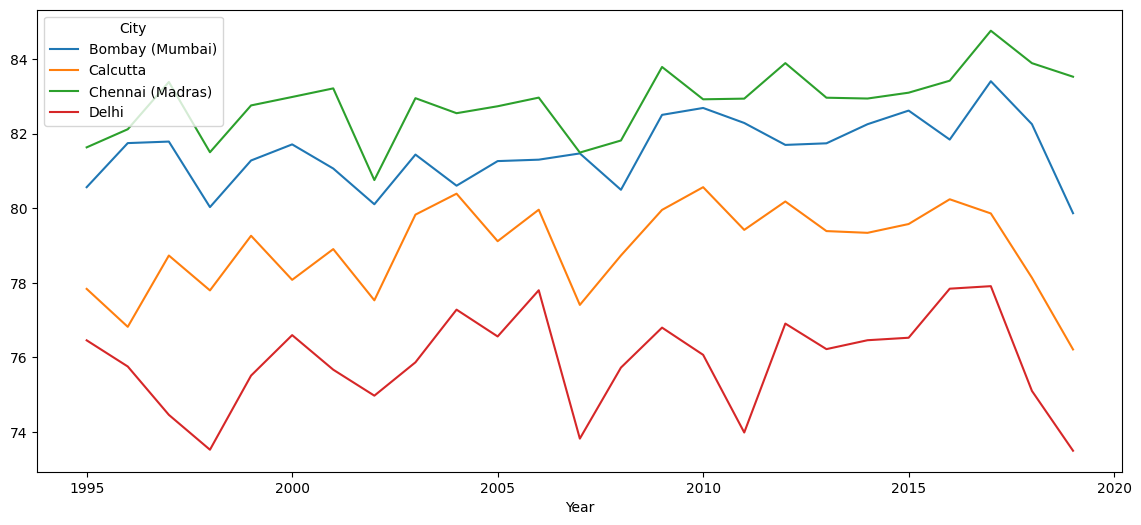

In [48]:
India_plot = data_India.groupby(['City', 'Year'])['AvgTemperature'].mean().reset_index()
India_pivot = India_plot.pivot(index='Year', columns='City', values='AvgTemperature')
India_pivot.plot()
plt.gcf().set_size_inches(14, 6)
plt.savefig("/content/Screenshots")
plt.show()

In [49]:
def season(df):
    if df in [12,1,2] :
        return 'Winter'
    elif  df in [3,4,5]:
        return 'Summer'
    elif df in [6,7,8]:
        return 'Monsoon'
    elif df in [9,10,11]:
        return 'Autumn'
    else:
        return 'NA'